In [19]:
from mxnet import autograd, nd, gluon
import mxnet as mx
from mxnet.gluon import data as gdata
import matplotlib.pyplot as plt
from mxnet.gluon import nn

In [2]:
def load_data(batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True)
    mnist_test = gdata.vision.FashionMNIST(train=False)
    
    transformer = gdata.vision.transforms.ToTensor()
    num_workers = 0 
    
    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

In [3]:
batch_size = 256
train_iter, test_iter = load_data(batch_size)

In [20]:
def initialize_parameters(n_x, n_y):
    mx.random.seed(0)
    parameters = {}
    W = nd.random.randn(n_y, n_x)
    b = nd.zeros((n_y, 1))
    W.attach_grad()
    b.attach_grad()
    
    parameters['W'] = W
    parameters['b'] = b
    
    return parameters

In [5]:
num_inputs = 784
num_outputs = 10
parameters = initialize_parameters(num_inputs, num_outputs)

In [16]:
def softmax(X):
    exp_sum = nd.exp(X).sum(axis=0)
    return nd.exp(X)/exp_sum

def compute_cost(Z, Y):
    A = softmax(Z)
    cost = -nd.pick(A, Y, axis=0).log()
    cost = cost.mean()
    cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    cost_ = cross_entropy_loss(Z.T, Y).mean()
    if cost.asscalar()-cost_.asscalar() > 10**-5:
        print('costself:{0}, costmxnet:{1}'.format(cost.asscalar(), cost_.mean().asscalar()))
    
    return cost

In [7]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=0)

(
 [[0.81326985 0.4348896  0.300823   0.39019507 0.74080414]
  [0.18673013 0.5651104  0.69917697 0.6098049  0.25919592]]
 <NDArray 2x5 @cpu(0)>, 
 [1. 1. 1. 1. 1.]
 <NDArray 5 @cpu(0)>)

In [8]:
def forward(X, parameters):
    X = X.reshape((X.shape[0], -1))
    W = parameters['W']
    b = parameters['b']
    Z = nd.dot(W, X.T) + b 
    
    return Z

def backward(X, Y, parameters):
    grads = {}
    with autograd.record():
        Z = forward(X, parameters)
        #print('-'*100)
        #print(parameters['W'][:, 0])
        #print(grads['dW'][:, 0])
        #print(Z[:10])
        cost = compute_cost(Z, Y)
        
    cost.backward()
    grads['dW'] = parameters['W'].grad
    grads['db'] = parameters['b'].grad
    
    return grads, cost

def update_parameters(grads, parameters, learning_rate):
    parameters['W'] -= grads['dW']*learning_rate
    parameters['b'] -= grads['db']*learning_rate
    
    return parameters

In [17]:
def model(train_iter, epoch_num=10, step=1, learning_rate=0.01):
    costs = []
    parameters = initialize_parameters(28*28, 10)
    for epoch in range(epoch_num):
        epoch_loss = 0 
        for X, Y in train_iter:
            grads, loss = backward(X, Y, parameters)
            parameters = update_parameters(grads, parameters, learning_rate)
            #loss += compute_cost(Z, Y)
            epoch_loss += loss.asscalar()
            #print('loss:{0}'.format(loss))
        epoch_loss /= len(train_iter)
        if epoch%step == 0:
            print('cost after {0} epochs is: {1}'.format(epoch, epoch_loss))
        costs.append(epoch_loss)
    
    plt.plot(costs)
    plt.xlabel('epoch number')
    plt.ylabel('batch cost')
    plt.title('leanring rate = {0}'.format(learning_rate))
    plt.show()
    
    return parameters
    

cost after 0 epochs is: 9.317329816615327
cost after 5 epochs is: 2.4905767958214944
cost after 10 epochs is: 2.011302125707586
cost after 15 epochs is: 1.775982942479722
cost after 20 epochs is: 1.6250575856959566
cost after 25 epochs is: 1.5175486239981144
cost after 30 epochs is: 1.4329503670651862
cost after 35 epochs is: 1.3665555226041917
cost after 40 epochs is: 1.3110915039448028
cost after 45 epochs is: 1.2642220598586063
cost after 50 epochs is: 1.223404376303896
cost after 55 epochs is: 1.1885906123100443
cost after 60 epochs is: 1.1564934930902846
cost after 65 epochs is: 1.12858516332951
cost after 70 epochs is: 1.1043196891216522
cost after 75 epochs is: 1.079802498411625
cost after 80 epochs is: 1.0580947845540147
cost after 85 epochs is: 1.0389355423602653
cost after 90 epochs is: 1.0213254124560254
cost after 95 epochs is: 1.0042731513368321


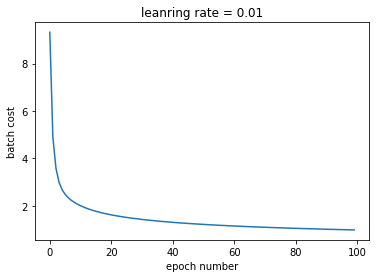

{'W': 
 [[ 1.1630117   0.4839526   0.29980433 ...  1.4863187  -0.39114088
   -1.0460408 ]
  [ 2.0690484  -0.1383806   1.1417035  ...  0.59182006  1.1150801
   -1.0921823 ]
  [-0.5239549   0.73422164 -0.83287853 ... -0.6728619  -0.8559436
   -1.6412416 ]
  ...
  [ 0.3878826   0.35712287 -0.60206294 ...  0.8623282   0.91948825
   -0.7210636 ]
  [ 1.1740454  -0.43278766  0.7110422  ... -0.7762402  -2.0872679
   -0.15785609]
  [ 0.5397571   0.9016035  -0.6591903  ...  1.0833082  -0.34086534
   -0.359893  ]]
 <NDArray 10x784 @cpu(0)>, 'b': 
 [[ 0.24132992]
  [-0.58963335]
  [-0.2093332 ]
  [ 0.4690094 ]
  [-1.2518296 ]
  [ 3.3239074 ]
  [ 0.5555383 ]
  [-0.30790234]
  [-0.49408248]
  [-1.7370055 ]]
 <NDArray 10x1 @cpu(0)>}

In [21]:
model(train_iter, epoch_num=100, step=5, learning_rate=0.01)

In [285]:
def model_gluon(train_iter, learning_rate=0.01, epoch_num=50, step=5):
    net = nn.Sequential()
    net.add(nn.Dense(10))
    net.initialize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    costs = []
    for epoch in range(epoch_num):
        train_loss = 0
        for X, y in train_iter:
            with autograd.record():
                Z = net(X)
                A = softmax(Z)
                #y = y.reshape(1, -1)
                loss = cross_entropy_loss(Z, y)
            loss.backward()
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()
        train_loss /= len(train_iter)
        costs.append(train_loss)
        
        if epoch%5 == 0:
            print('after {0} epoch, cost is {1}'.format(epoch, train_loss))
            
    plt.plot(costs)
    plt.xlabel('epoch number')
    plt.ylabel('batch cost')
    plt.title('leanring rate = {0}'.format(learning_rate))
    plt.show()
    
    #print(net[0])
    return net

after 0 epoch, cost is 1.3672696009595344
after 5 epoch, cost is 0.6823967149917115
after 10 epoch, cost is 0.6024525864327207
after 15 epoch, cost is 0.5636627899839523
after 20 epoch, cost is 0.5391586741234394
after 25 epoch, cost is 0.522347468771833
after 30 epoch, cost is 0.5097038047110781
after 35 epoch, cost is 0.4988610362752955
after 40 epoch, cost is 0.490990922552474
after 45 epoch, cost is 0.48372284224692813
after 50 epoch, cost is 0.4780674272395195
after 55 epoch, cost is 0.47282729757593034
after 60 epoch, cost is 0.46786496651933546


Exception ignored in: <bound method NDArrayBase.__del__ of 
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 10]
  [ 72]
  [ 61]
  [ 31]
  [ 18]
  [104]
  [ 52]
  [  0]
  [  0]
  [  0]
  [  1]
  [  1]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 73]
  [113]
  [101]
  [128]
  [119]
  [212]
  [111]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  3]
  [ 33]
  [ 58]
  [ 75]
  [ 55]
  [ 92]
  [153]
  [230]
  [255]
  [209]
  [  0]
  [ 54]
  [ 76]
  [ 54]
  [ 43]
  [ 18]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  7]
  [ 79]
  [ 84]
  [ 89]
  [ 84]
  [ 75]
  [ 78]
  [182]
  [135]
  [178]
  [135]
  [119]
  [ 49]
  [ 42]
  [ 69]
  [ 69]
  [ 81]
  [ 72]
  [ 18]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [ 

after 65 epoch, cost is 0.46416551217119745
after 70 epoch, cost is 0.4605350545112123
after 75 epoch, cost is 0.45676986613172166
after 80 epoch, cost is 0.45382385177815215
after 85 epoch, cost is 0.45099089082251204
after 90 epoch, cost is 0.4487555096758173
after 95 epoch, cost is 0.4462603698385523


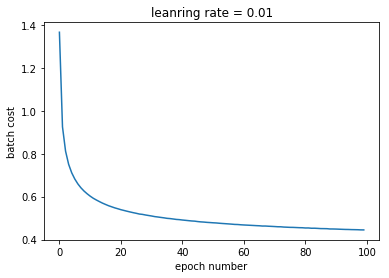

In [274]:
net = nn.Sequential()
net = model_gluon(train_iter, epoch_num=100)